### Aprendizado de máquina - Trabalho prático 1
- Nome: Cristiano Moreira Martins 
- Matrícula: 11111871-7

# Conjunto de dados
- O conjunto de dados selecionado é referente as informações cadastrais e cotações de fundos de investimento no intervalo 2018-2021 disponobilizado no portal de dados abertos:
- <li>https://dados.cvm.gov.br/dataset/fi-cad</li> 
- <li>https://dados.cvm.gov.br/dataset/fi-doc-inf_diario</li>

##### O objetivo é verificar se algumas métricas como retornos e volatilidade podem ser utilizadas para classificar os fundos conforme o comportamento do histórico de preços. Com isso, poderia-se planejar recomendações mais acertadas conforme o risco que os investidores estão dispostos a aceitar.


# Análise

In [1]:
import zipfile
import io
import datetime

import pandas as pd
import numpy as np
import empyrical as ep
import matplotlib.pyplot as plt

from urllib.request import urlopen
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
class Tools:
    def load_informe_diario(self, start_year, end_year, to_csv_file_name=False, sep=','):

        years = np.arange(start_year, end_year + 1, 1)
        months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

        # Part 1: Import and read most recent CVM data.
        data = pd.DataFrame()
        url_base = 'http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS'
        for year in years:
            url = f'{url_base}/HIST/inf_diario_fi_{year}.zip'
            
            df_temp = self.read_remote_zipfile(url)
            if len(df_temp) > 0:
                data = pd.concat([data, df_temp], axis=0)
                print(f'...imported {year} - {len(df_temp)} regs ✓ (in HIST)')
            else:
                for month in months:
                    url = f'{url_base}/inf_diario_fi_{year}{month}.zip'
                    df_temp = self.read_remote_zipfile(url)
                    if len(df_temp) > 0:
                        data = pd.concat([data, df_temp], axis=0)
                        print(f'...imported {year}/{month} - {len(df_temp)} regs ✓')

        data = data.set_index('DT_COMPTC').sort_index()
        print(f'loaded {len(data)} registers')

        if to_csv_file_name is False:
            return data

        else:
            if isinstance(to_csv_file_name, str):
                if to_csv_file_name[-4:] == '.csv':
                    data.to_csv(to_csv_file_name, sep=sep)
                    return None
                else:
                    data.to_csv(to_csv_file_name+'.csv', sep=sep)
                    return None
            else:
                raise Exception('Error: "to_csv_file_name" must be a string')
            
    def read_remote_zipfile(self, url):
        
        data = pd.DataFrame()
        try:
            remotezip = urlopen(url)
            zipinmemory = io.BytesIO(remotezip.read())
            zip = zipfile.ZipFile(zipinmemory)
            for fn in zip.namelist():
                if fn.endswith(".csv"):
                    file = (zip.open(fn))
                    cvm_data = pd.read_csv(file, sep=';')
                    data = pd.concat([data, cvm_data], axis=0)
        except Exception:
            pass
        return data

### Data preparation
- select data
- clean data
- construct data
- dataset

In [3]:
# load data
tools = Tools()
path = 'D:/Disco/Data/CVM/'

info_cadastral = 'https://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'

info_cad_df = pd.read_csv(info_cadastral, encoding='cp1252', sep=';')
quotes_df = tools.load_informe_diario(start_year=2018, end_year=datetime.date.today().year)
#quotes_df = pd.read_csv(f'{path}inf_diario_all.csv', encoding='cp1252', converters={'CNPJ_FUNDO':str}, parse_dates=['DT_COMPTC'])
#quotes_df = quotes_df[quotes_df['DT_COMPTC'].dt.year >= 2018]

print(len(info_cad_df), len(quotes_df))

C:\Users\crist\AppData\Local\Temp\ipykernel_63832\2412428167.py:7: DtypeWarning: Columns (14,17,18,20,22,24,27,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  info_cad_df = pd.read_csv(info_cadastral, encoding='cp1252', sep=';')


...imported 2018 - 3589065 regs ✓ (in HIST)
...imported 2019 - 3936054 regs ✓ (in HIST)
...imported 2020 - 4491389 regs ✓ (in HIST)
...imported 2021/01 - 389625 regs ✓
...imported 2021/02 - 355168 regs ✓
...imported 2021/03 - 460407 regs ✓
...imported 2021/04 - 407176 regs ✓
...imported 2021/05 - 434213 regs ✓
...imported 2021/06 - 441178 regs ✓
...imported 2021/07 - 469766 regs ✓
...imported 2021/08 - 476411 regs ✓
...imported 2021/09 - 460276 regs ✓
...imported 2021/10 - 443413 regs ✓
...imported 2021/11 - 448543 regs ✓
...imported 2021/12 - 522539 regs ✓
...imported 2022/01 - 480909 regs ✓
...imported 2022/02 - 437388 regs ✓
...imported 2022/03 - 509156 regs ✓
...imported 2022/04 - 442702 regs ✓
...imported 2022/05 - 515505 regs ✓
...imported 2022/06 - 496430 regs ✓
...imported 2022/07 - 500546 regs ✓
...imported 2022/08 - 551185 regs ✓
...imported 2022/09 - 506331 regs ✓
...imported 2022/10 - 485486 regs ✓
...imported 2022/11 - 488756 regs ✓
...imported 2022/12 - 539894 regs ✓
...i

In [4]:
info_cad_df.head()

,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR,INVEST_CEMPR_EXTER,CLASSE_ANBIMA
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCE...,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INV...,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC ...,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIME...,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
quotes_df.head()

,CNPJ_FUNDO,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST,TP_FUNDO
DT_COMPTC,,,,,,,,
2018-01-02,00.017.024/0001-53,1130197.89,25.968274,1130221.60,0.0,0.00,1,NaN
2018-01-02,26.695.465/0001-06,56742090.83,1.100419,56726368.69,0.0,0.00,1,NaN
2018-01-02,09.643.664/0001-43,52005419.59,2.659632,51809479.80,26000.0,282592.35,10,NaN
2018-01-02,09.643.616/0001-55,3468900.40,2.702850,3468256.21,0.0,0.00,2,NaN
2018-01-02,09.643.547/0001-80,21060214.21,2.328973,21043005.37,0.0,0.00,5,NaN


### select & clean
- Serão selecionados os fundos que estão em funcionamento (SIT == EM FUNCIONAMENTO NORMAL)
- fundos que não são exclusivos (FUNDO_EXCLUSIVO == N)
  - pois geralmente são fundos fechados para investidores em geral ou são fundos relacionados ao patrimônio de alguma pessoa ou família
- fundos pertencentes as classes Renda Fixa, Ações, Multimercado


In [6]:
# select and clean
info_cad_df['CNPJ_FUNDO'] = info_cad_df['CNPJ_FUNDO'].str.replace('.', '').str.replace('-', '').str.replace('/', '')
quotes_df['CNPJ_FUNDO'] = quotes_df['CNPJ_FUNDO'].str.replace('.', '').str.replace('-', '').str.replace('/', '')

info_cad_df = info_cad_df[
    (info_cad_df['SIT'] == 'EM FUNCIONAMENTO NORMAL') 
    & (info_cad_df['FUNDO_EXCLUSIVO'] == 'N' )
    & (info_cad_df['CLASSE'].isin(['Renda Fixa', 'Ações', 'Multimercado']))]

#filtra as cotações, permanecendo apenas os que estao ativos
#quotes_df[]

info_cad_df.set_index('CNPJ_FUNDO', inplace=True)

quotes_df.reset_index(inplace=True)
quotes_df.set_index('CNPJ_FUNDO', inplace=True)

quotes_df, _ = quotes_df.align(info_cad_df, axis=0, join='inner')

#seleciona as colunas
info_cad_df = info_cad_df[['TP_FUNDO', 'DENOM_SOCIAL', 'CLASSE']]
quotes_df = quotes_df[['DT_COMPTC', 'VL_TOTAL', 'VL_QUOTA', 'VL_PATRIM_LIQ']]

print(len(info_cad_df), len(quotes_df))

C:\Users\crist\AppData\Local\Temp\ipykernel_63832\2131514232.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  info_cad_df['CNPJ_FUNDO'] = info_cad_df['CNPJ_FUNDO'].str.replace('.', '').str.replace('-', '').str.replace('/', '')
C:\Users\crist\AppData\Local\Temp\ipykernel_63832\2131514232.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  quotes_df['CNPJ_FUNDO'] = quotes_df['CNPJ_FUNDO'].str.replace('.', '').str.replace('-', '').str.replace('/', '')


17986 19427906


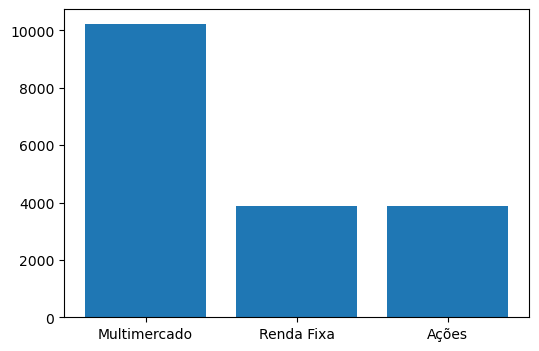

In [7]:
class_counts = info_cad_df['CLASSE'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.show()

In [8]:
# ajusta a quantidade de classes pois a classe multimercado possui mais elementos
renda_fixa_df = info_cad_df[info_cad_df['CLASSE'] == 'Renda Fixa']
acoes_df = info_cad_df[info_cad_df['CLASSE'] == 'Ações']
multimercado_df = info_cad_df[info_cad_df['CLASSE'] == 'Multimercado']

min_class_count = min(len(renda_fixa_df), len(acoes_df))

multimercado_df = multimercado_df.sample(n=min_class_count, random_state=42)

balanced_df = pd.concat([renda_fixa_df, acoes_df, multimercado_df])
info_cad_df = balanced_df.sample(frac=1, random_state=42)

del renda_fixa_df, acoes_df, multimercado_df


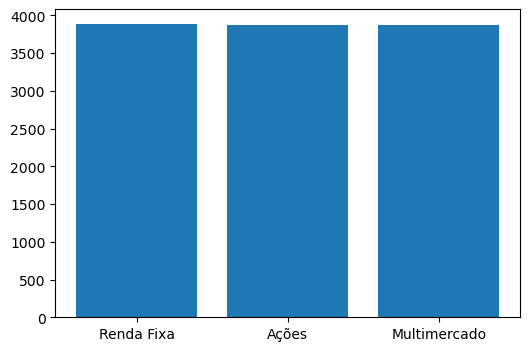

In [9]:
class_counts = balanced_df['CLASSE'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values)
plt.show()

In [10]:
#filtra novamente 
quotes_df, _ = quotes_df.align(info_cad_df, axis=0, join='inner')

print(len(info_cad_df), len(quotes_df))

11634 13261900


### construct
- Criação de features para serem utilizadas nos modelos
- será calculada a volatilidade e os retornos totais nos períodos de 1,2 e 3 anos

In [11]:

# o cálculo demora, recomenda-se pegar uma amostra dos dados
#info_cad_df = info_cad_df.sample(frac=.25)

y1 = 252
y2 = 504
y3 = 756

for cnpj in pd.unique(info_cad_df.index):
    data = quotes_df[quotes_df.index == cnpj][['DT_COMPTC','VL_QUOTA']].set_index('DT_COMPTC')
    data = ep.stats.simple_returns(data[['VL_QUOTA']])
    if len(data) >= y3:
        info_cad_df.loc[cnpj, 'std'] = ep.annual_volatility(data)[0]
        info_cad_df.loc[cnpj, 'std_1y'] = ep.annual_volatility(data.tail(y1))[0]
        info_cad_df.loc[cnpj, 'std_2y'] = ep.annual_volatility(data.tail(y2))[0]
        info_cad_df.loc[cnpj, 'std_3y'] = ep.annual_volatility(data.tail(y3))[0]
        info_cad_df.loc[cnpj, 'ret'] = ep.annual_return(data)[0]
        info_cad_df.loc[cnpj, 'ret_1y'] = ep.annual_return(data.tail(y1))[0]
        info_cad_df.loc[cnpj, 'ret_2y'] = ep.annual_return(data.tail(y2))[0]
        info_cad_df.loc[cnpj, 'ret_3y'] = ep.annual_return(data.tail(y3))[0]

info_cad_df.dropna(inplace=True)

In [12]:
info_cad_df.to_csv(f'{path}info_bkp.csv')
quotes_df.to_csv(f'{path}quotes_bkp.csv')
#info_cad_df = pd.read_csv(f'{path}bkp.csv')
#info_cad_df.dropna(inplace=True)

### Modeling
- select modeling techniques
- generate test design
- build model
- asses model

###
- Serão utilizados K-nn, Naive Bayes e Decision Tree para avaliar se os modelos conseguem classificar cada fundo conforme a sua classe especificada em relação a métricas de volatilidade e retorno

#### build model

In [17]:
X = info_cad_df[['std', 'std_1y', 'std_2y', 'std_3y', 'ret', 'ret_1y', 'ret_2y', 'ret_3y']]
y = info_cad_df['CLASSE']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### KNN

In [18]:
knn_params = {'n_neighbors': [2, 3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, knn_params, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)
best_knn = grid_knn.best_estimator_
print("Melhor Configuração k-NN:", grid_knn.best_params_)
print("Acurácia:", grid_knn.best_score_)

Melhor Configuração k-NN: {'n_neighbors': 7, 'weights': 'distance'}
Acurácia: 0.8596463149654638


##### Naive Bayes

In [15]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred_nb = nb.predict(X_test_scaled)
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

       Ações       0.76      0.93      0.84       522
Multimercado       0.56      0.05      0.08       510
  Renda Fixa       0.56      0.97      0.71       495

    accuracy                           0.65      1527
   macro avg       0.63      0.65      0.55      1527
weighted avg       0.63      0.65      0.55      1527



##### Decision Tree

In [16]:
dt_params = {'max_depth': [2, 3, 5, 7, 10], 'min_samples_split': [2, 5, 10]}
dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy')
grid_dt.fit(X_train_scaled, y_train)
best_dt = grid_dt.best_estimator_
print("\nMelhor Configuração Decision Tree:", grid_dt.best_params_)
print("Acurácia:", grid_dt.best_score_)


Melhor Configuração Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
Acurácia: 0.8452347154474815


### Evaluation
- evaluate results

- O modelo que apresentou o melhor resultado foi o KNN, com a acurácia de 0,84. Decision Tree performou de forma semelhante, mas um pouco abaixo quando comparada a acurácia e o Naive Bayes não performou bem.
- Naive Bayes apresentou problemas para classificar corretamente as classes Renda Fixa e Multimercado. O problema aqui é pelo seguinte motivo: Os fundos multimercado podem ter a composição da carteira semelhante a fundos classificados como Renda Fixa ou Ações, o que difere esses fundos, para fins de classificação é os tipos de ativos que podem ser incorporados na carteira dos fundos multimercado em que existe, por exemplo, maior liberdade de escolha de ativos quando comparado a um fundo de Renda Fixa que é obrigado a ter em seu portfófio somente ativos classificados como tal 


